In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set(color_codes = True)

# Tell iPython to include plots inline in the notebook
%matplotlib inline

data_gop = pd.read_csv('gop_Sentiment.csv')
print "GOP Dataset has {} rows, {} columns".format(*data_gop.shape)  # * unpacks the shape tuple

GOP Dataset has 13871 rows, 21 columns


In [2]:
#A lot of information we really aren't interested in, so take a look at the columns with their index.
header_index = [(i,z) for z,i in enumerate(data_gop.columns.view())]
print header_index

[(' id', 0), ('candidate', 1), ('candidate_confidence', 2), ('relevant_yn', 3), ('relevant_yn_confidence', 4), ('sentiment', 5), ('sentiment_confidence', 6), ('subject_matter', 7), ('subject_matter_confidence', 8), ('candidate_gold', 9), ('name', 10), ('relevant_yn_gold', 11), ('retweet_count', 12), ('sentiment_gold', 13), ('subject_matter_gold', 14), ('text', 15), ('tweet_coord', 16), ('tweet_created', 17), ('tweet_id', 18), ('tweet_location', 19), ('user_timezone', 20)]


In [3]:
#Now we can drop the ones we won't be using. We are keeping ID-0, sentiment-5,  text-15.
#set the index to ' id' and the the other two columns as sentiment and tweet
df_gop = pd.DataFrame(index = data_gop[' id'])
df_gop = data_gop[['sentiment','text']].copy()
print df_gop.head()

  sentiment                                               text
0   Neutral  RT @NancyLeeGrahn: How did everyone feel about...
1  Positive  RT @ScottWalker: Didn't catch the full #GOPdeb...
2   Neutral  Re-SubmissionT @TJMShow: No mention of Tamir R...
3  Positive  RT @RobGeorge: That Carly Fiorina is trending ...
4  Positive  RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [4]:
#let's look for what kinds of unique values we have in our sentiment scoring category.
# We should also check if we have NaN's that we'd want to deal with
print df_gop.sentiment.unique()
print ""
print "Columns have null values?"
print df_gop.isnull().any()

['Neutral' 'Positive' 'Negative']

Columns have null values?
sentiment    False
text         False
dtype: bool


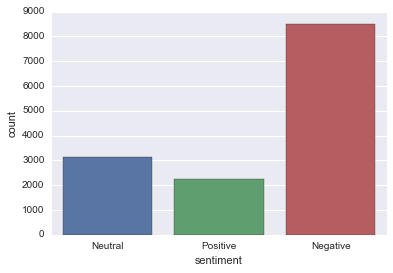

In [5]:
sns.countplot( x = 'sentiment' , data = df_gop)

In [6]:
#we will want our labels numeric (some classifiers may not like 3-way text labels),
#we can do that all now.

df_gop.sentiment.replace(['Positive', 'Negative', 'Neutral'], [1, -1 , 0], inplace = True)
print "gop tweets \n"
print df_gop[:10]

gop tweets 

   sentiment                                               text
0          0  RT @NancyLeeGrahn: How did everyone feel about...
1          1  RT @ScottWalker: Didn't catch the full #GOPdeb...
2          0  Re-SubmissionT @TJMShow: No mention of Tamir R...
3          1  RT @RobGeorge: That Carly Fiorina is trending ...
4          1  RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
5          1  RT @GregAbbott_TX: @TedCruz: "On my first day ...
6         -1  RT @warriorwoman91: I liked her and was happy ...
7          0  Going on #MSNBC Live with @ThomasARoberts arou...
8         -1  Deer in the headlights RT @lizzwinstead: Ben C...
9         -1  RT @NancyOsborne180: Last night's debate prove...


In [7]:
# Let's take a look at our class distribution
total_tweets = len(df_gop)
positive_tweets = sum(df_gop.sentiment == 1)
negative_tweets = sum(df_gop.sentiment == -1)
neutral_tweets = sum(df_gop.sentiment == 0)

print "The total number of samples is : {}".format(len(df_gop.sentiment))
print "There are {} positive tweets or {}%".format \
(positive_tweets, positive_tweets/float(total_tweets) )
print "There are {} Negative tweets or {}%".format \
(negative_tweets, negative_tweets / float(total_tweets))
print "There are {} Neutral tweets or {}%".format \
(neutral_tweets, neutral_tweets/ float(total_tweets))

The total number of samples is : 13871
There are 2236 positive tweets or 0.161199625117%
There are 8493 Negative tweets or 0.612284622594%
There are 3142 Neutral tweets or 0.226515752289%


# Preprocess the Tweets
We need to do a few steps before we can use the tweets to produce features.
- parse the tweets into single words
- remove retweets, these don't add any sentiment value
- remove urls, same as above.
- remove stop-words same as above

I am passing the bulk of the parsing to the ARK tokenizer from CMU, in this case we are using a python port of the original Java.  link to the port is : https://github.com/myleott/ark-twokenize-py

In [8]:
# ok let's parse some sample the tweets use the ARK tokenizer from CMU.
import twokenize as tw

first_tweet = df_gop.iloc[0, 1]
second_tweet = df_gop.iloc[1,1]
third_tweet = df_gop.iloc[2,1]

test_tweets = [first_tweet, second_tweet, third_tweet]
for tweet in test_tweets:
    print tweet

print ""

for tweet in test_tweets:
    print tw.tokenizeRawTweetText(tweet)

RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate
RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…
Re-SubmissionT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.

['RT', '@NancyLeeGrahn', ':', 'How', 'did', 'everyone', 'feel', 'about', 'the', 'Climate', 'Change', 'question', 'last', 'night', '?', 'Exactly', '.', '#GOPDebate']
['RT', '@ScottWalker', ':', "Didn't", 'catch', 'the', 'full', '#GOPdebate', 'last', 'night', '.', 'Here', 'are', 'some', 'of', "Scott's", 'best', 'lines', 'in', '90', 'seconds', '.', '#Walker16', 'http://t.co/ZSfF\xe2\x80\xa6']
['Re-SubmissionT', '@TJMShow', ':', 'No', 'mention', 'of', 'Tamir', 'Rice', 'and', 'the', '#GOPDebate', 'was', 'held', 'in', 'Cleveland', '?', 'Wow', '.']


## OK that works for a rough parse well enough, let's remove the stop words, RT's and links now.  The words found in stopwords.txt came from this site:
http://www.ranks.nl/stopwords


In [9]:
#stop-word removal
with open('stopwords.txt') as f:
    stop_words = f.read().splitlines()
print stop_words

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", "i'm", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselv

In [10]:
# compile a regex for stop words, urls, rt's, etc

retweets = re.compile(r'(rt ?@.*?:)')   
urls = re.compile(r'(https?:.*\b)')
extras = re.compile(r"\.|\.\.|I|The|:|'|,|\"")
stop_word = re.compile(r'\b({})\b'.format('|'.join(stop_words)))

regex_args = [retweets, urls, extras,  stop_word]
#make a method to easily use our regex : note we do not want to compile the regex within this def, that would be computationally expensive.
def parse_tweet (tweet , *args):
    tweet = tweet.lower()
    for arg in args:
        tweet = re.sub(arg, "", tweet)
    tweet = tw.tokenizeRawTweetText(tweet)
    if len(tweet) < 1:
        return "NaN"
    else:
        return tweet

for tweet in test_tweets:
    print parse_tweet(tweet, *regex_args)

['everyone', 'feel', 'climate', 'change', 'question', 'last', 'night', '?', 'exactly', '#gopdebate']
['didnt', 'catch', 'full', '#gopdebate', 'last', 'night', 'scotts', 'best', 'lines', '90', 'seconds', '#walker16', '\xe2\x80\xa6']
['re-submissiont', '@tjmshow', 'mention', 'tamir', 'rice', '#gopdebate', 'held', 'cleveland', '?', 'wow']


## Ok that's working well enough, let's parse all the tweets in the data frame now

In [11]:
#parse all tweets in dataframe
# ok, now that we have rough parsing, lets parse them all!
#run a decoder on unicode, cause 
df_gop.text = df_gop.text.apply(lambda x: x.decode('utf-8'))
df_gop.text = df_gop.text.apply(lambda x: parse_tweet(x,*regex_args))
print df_gop.head()
print df_gop.shape

   sentiment                                               text
0          0  [everyone, feel, climate, change, question, la...
1          1  [didnt, catch, full, #gopdebate, last, night, ...
2          0  [re-submissiont, @tjmshow, mention, tamir, ric...
3          1  [carly, fiorina, trending, --, hours, debate, ...
4          1  [#gopdebate, w/, @realdonaldtrump, delivered, ...
(13871, 2)


In [12]:
# let's check to make sure we didnt' parse anything down to an empty string or became NaN
print df_gop.isnull().any()
print np.where(df_gop.applymap(lambda x: x == ''))

sentiment    False
text         False
dtype: bool
(array([], dtype=int64), array([], dtype=int64))


size of training tweets:  10403
size of testing tweets:  3468


<function matplotlib.pyplot.show>

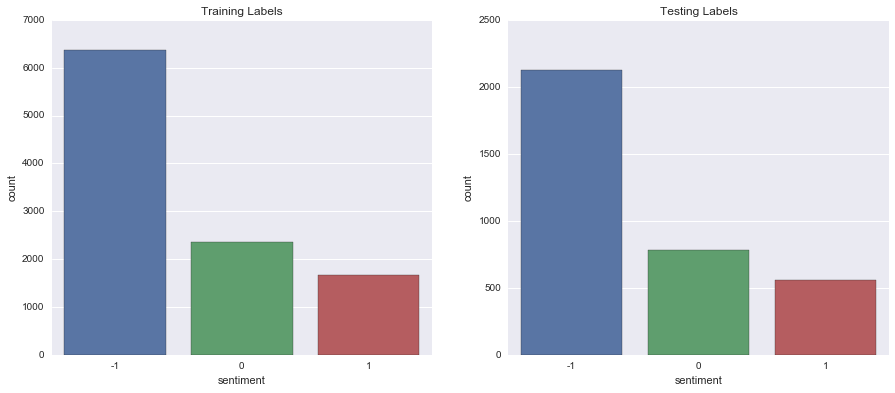

In [13]:
# now that we have all the tweets parsed, we actually want to split into our training / testing sets. 
# This is because n-gram analysis (which comes next), should not be done on the testing data!  
# The n-gram analysis should on be on training data.  

# TODO try to implement n-gram analysis with cross validation, for now I'll use a hold-out testing set
from sklearn import cross_validation

#Let's split up the labels from the training data

X_all = df_gop['text']
y_all = df_gop['sentiment']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        X_all, y_all, test_size=0.25, stratify = y_all, random_state = 0)  #note we run stratify, in order to try and keep a balanced labeled set

print "size of training tweets: ", len(X_train)
print "size of testing tweets: ", len(X_test)

plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
ax = sns.countplot(y_train)
ax.set_title("Training Labels")
plt.subplot(1,2,2)
ax = sns.countplot(y_test)
ax.set_title("Testing Labels")
plt.show

In [14]:
# we need to merge the labels and parsed tweets for doing our n-gram analysis.
# This is because we will build n-gram models for each class, therefore we need to select only
# those tweets that are positive / negative for the two n-gram tables.

# Let's re-merge the labels into the training data order to do n-gram analysis
XyN_gram = pd.concat([X_train, y_train], axis = 1)

print XyN_gram.iloc[0, 0]
print XyN_gram.head()

[u'ok', u'can', u'cull', u'herd', u'two', u'#gopdebates', u'?', u'can', u'tell', u'pataki', u'carson', u'walker', u'cruz', u'perry', u'go', u'home', u'?']
                                                    text  sentiment
10194  [ok, can, cull, herd, two, #gopdebates, ?, can...         -1
1811   [dont, like, @megynkelly, will, defend, obnoxi...          1
4223   [can, just, build, fence, around, trump, ?, #g...         -1
12201  [#plannedparenthood, funded, florida, -, flori...         -1
8859   [many, great, jokes, twitter, tonight, #gopdeb...         -1


In [15]:
from collections import defaultdict
#Let's start by developing a function that will take a parsed tweet and count the number of grams of any size
def nGram_counter (parsed_tweet, distance_to_cover, gram_map):
    for_loop_range = range(len(parsed_tweet) - distance_to_cover)    
    for i in for_loop_range:
        gram = tuple(parsed_tweet[i:i+distance_to_cover])
        gram_map[gram] +=1
        
   

In [16]:
# ok let's try out the above function and make sure it's doing what we think
# we will use the same test tweet as before 
# test1 = [u'ok', u',', u'can', u'cull', u'herd', u'two', u'#gopdebates', u'?', u'can', u'tell', u'pataki', u',', u'carson', u',', u'walker', u',', u'cruz', u'perry', u'go', u'home', u'?']

test1 = XyN_gram.iloc[0,0]

test_uni = defaultdict(int)
test_bi = defaultdict(int)
test_tri = defaultdict(int)

nGram_counter(test1, 3, test_tri)
nGram_counter(test1, 2, test_bi)
nGram_counter(test1, 1, test_uni)
# check our output.
print "the test tweet: {}".format(test1)
print ""
print test_uni
print " "
print test_bi
print " "
print test_tri
print " "

the test tweet: [u'ok', u'can', u'cull', u'herd', u'two', u'#gopdebates', u'?', u'can', u'tell', u'pataki', u'carson', u'walker', u'cruz', u'perry', u'go', u'home', u'?']

defaultdict(<type 'int'>, {(u'herd',): 1, (u'can',): 2, (u'cull',): 1, (u'tell',): 1, (u'perry',): 1, (u'?',): 1, (u'ok',): 1, (u'go',): 1, (u'pataki',): 1, (u'#gopdebates',): 1, (u'carson',): 1, (u'cruz',): 1, (u'two',): 1, (u'walker',): 1, (u'home',): 1})
 
defaultdict(<type 'int'>, {(u'perry', u'go'): 1, (u'herd', u'two'): 1, (u'cruz', u'perry'): 1, (u'can', u'cull'): 1, (u'cull', u'herd'): 1, (u'#gopdebates', u'?'): 1, (u'tell', u'pataki'): 1, (u'can', u'tell'): 1, (u'two', u'#gopdebates'): 1, (u'go', u'home'): 1, (u'?', u'can'): 1, (u'ok', u'can'): 1, (u'carson', u'walker'): 1, (u'pataki', u'carson'): 1, (u'walker', u'cruz'): 1})
 
defaultdict(<type 'int'>, {(u'walker', u'cruz', u'perry'): 1, (u'can', u'cull', u'herd'): 1, (u'ok', u'can', u'cull'): 1, (u'herd', u'two', u'#gopdebates'): 1, (u'can', u'tell', u'pat

In [17]:
#let's now apply our n-gram counter to all the tweets of a certain class.

def n_gram_counter (tweets, map1, map2, map3, classtype):
    tweets.apply(lambda x: nGram_counter(x.text, 1, map1), 1)
    tweets.apply(lambda x: nGram_counter(x.text, 2, map2), 1)
    tweets.apply(lambda x: nGram_counter(x.text, 3, map3), 1)
    print "Total Unigrams for {} Tweets : {}".format(classtype, len(map1))
    print 
    print "Total Bi-grams for {} Tweets: {}".format(classtype, len(map2))
    print
    print "Total Tri-grams for {} Tweets: {}".format(classtype, len(map3))
    print
    print "Most popular {} Uni-grams : {}" \
    .format(classtype, sorted(map1.items(), key=lambda x: x[1], reverse = True)[:15])
    print
    print "Most Popular {}  Bi-gams : {}" \
    .format(classtype, sorted(map2.items(), key = lambda x: x[1], reverse = True)[:15])
    print
    print "Most popular {} Tri-grams : {}" \
    .format(classtype, sorted(map3.items(), key=lambda x: x[1], reverse = True)[:15])
    

In [18]:
#initialize the neutral tweets, and their respective maps.  We use a pre-initialized map, because we want to use
#apply on the dataframe, and this way nothing needs to be returned by the counting function.

neutral_tweets = XyN_gram[XyN_gram.sentiment == 0]
neutral_uni_grams = defaultdict(int)
neutral_bi_grams = defaultdict(int)
neutral_tri_grams = defaultdict(int)

n_gram_counter(neutral_tweets, neutral_uni_grams, neutral_bi_grams, neutral_tri_grams, "Neutral")

Total Unigrams for Neutral Tweets : 5003

Total Bi-grams for Neutral Tweets: 12261

Total Tri-grams for Neutral Tweets: 11949

Most popular Neutral Uni-grams : [((u'#gopdebate',), 940), ((u'?',), 348), ((u'#gopdebates',), 240), ((u'last',), 224), ((u'trump',), 219), ((u'!',), 184), ((u'debate',), 164), ((u'&',), 122), ((u'night',), 122), ((u'candidates',), 112), ((u'-',), 112), ((u'will',), 103), ((u'\U0001f1fa\U0001f1f8',), 103), ((u'@realdonaldtrump',), 102), ((u'one',), 99)]

Most Popular Neutral  Bi-gams : [((u'last', u'night'), 105), ((u'last', u'nights'), 88), ((u'\U0001f1fa\U0001f1f8', u'#gopdebate'), 85), ((u'nights', u'#gopdebate'), 53), ((u'fox', u'news'), 50), ((u'#gopdebate', u'last'), 47), ((u'donald', u'trump'), 35), ((u'#gopdebate', u'?'), 32), ((u'gop', u'debate'), 32), ((u'?', u'#gopdebate'), 30), ((u'cruz', u'trump'), 30), ((u'rubio', u'\U0001f1fa\U0001f1f8'), 28), ((u'get', u'rid'), 28), ((u'together', u'expose'), 28), ((u'trump', u'need'), 28)]

Most popular Neutral

In [19]:
#Ok let's do that again, for positive tweets now

positive_tweets = XyN_gram[XyN_gram.sentiment == 1]
positive_uni_grams = defaultdict(int)
positive_bi_grams = defaultdict(int)
positive_tri_grams = defaultdict(int)

n_gram_counter(positive_tweets, positive_uni_grams, positive_bi_grams, positive_tri_grams, "Positive")

Total Unigrams for Positive Tweets : 3459

Total Bi-grams for Positive Tweets: 9017

Total Tri-grams for Positive Tweets: 8893

Most popular Positive Uni-grams : [((u'#gopdebate',), 764), ((u'trump',), 279), ((u'!',), 235), ((u'@realdonaldtrump',), 227), ((u'\U0001f1fa\U0001f1f8',), 220), ((u'#gopdebates',), 212), ((u'debate',), 144), ((u'last',), 132), ((u'&',), 115), ((u'fox',), 110), ((u'rubio',), 107), ((u'news',), 105), ((u'night',), 102), ((u'cruz',), 97), ((u'?',), 92)]

Most Popular Positive  Bi-gams : [((u'\U0001f1fa\U0001f1f8', u'#gopdebate'), 197), ((u'fox', u'news'), 91), ((u'last', u'night'), 80), ((u'@realdonaldtrump', u's'), 60), ((u's', u'ratings'), 58), ((u'youre', u'raising'), 55), ((u'thanks', u'fox'), 55), ((u'raising', u'@realdonaldtrump'), 55), ((u'news', u'youre'), 55), ((u'ratings', u'\U0001f1fa\U0001f1f8'), 54), ((u'get', u'rid'), 51), ((u'rubio', u'\U0001f1fa\U0001f1f8'), 50), ((u'together', u'expose'), 50), ((u'trump', u'need'), 50), ((u'set', u'job'), 50)]



In [20]:
#Ok let's do that again, for the negative tweets now

negative_tweets = XyN_gram[XyN_gram.sentiment == -1]
negative_uni_grams = defaultdict(int)
negative_bi_grams = defaultdict(int)
negative_tri_grams = defaultdict(int)

n_gram_counter(negative_tweets, negative_uni_grams, negative_bi_grams, negative_tri_grams, "Negative")

Total Unigrams for Negative Tweets : 8948

Total Bi-grams for Negative Tweets: 31465

Total Tri-grams for Negative Tweets: 32424

Most popular Negative Uni-grams : [((u'#gopdebate',), 2614), ((u'?',), 1162), ((u'\U0001f1fa\U0001f1f8',), 902), ((u'#gopdebates',), 862), ((u'fox',), 777), ((u'trump',), 663), ((u'&',), 520), ((u'!',), 504), ((u'news',), 490), ((u'just',), 452), ((u'debate',), 436), ((u'@realdonaldtrump',), 435), ((u'candidates',), 425), ((u'jeb',), 385), ((u'dont',), 382)]

Most Popular Negative  Bi-gams : [((u'\U0001f1fa\U0001f1f8', u'#gopdebate'), 703), ((u'fox', u'news'), 464), ((u'?', u'#gopdebate'), 231), ((u'jeb', u'bush'), 211), ((u'chris', u'wallace'), 204), ((u'last', u'night'), 199), ((u'donald', u'trump'), 165), ((u'#gopdebate', u'#gopdebates'), 145), ((u'fair', u'&'), 139), ((u'&', u'balanced'), 137), ((u'\U0001f1fa\U0001f1f8', u'#gopdebates'), 132), ((u'bush', u'reminds'), 126), ((u'listen', u'\U0001f1fa\U0001f1f8'), 125), ((u'reminds', u'elevator'), 125), ((u

In [23]:
#Ok let's do that again, for the negative tweets now

all_training_tweets = XyN_gram
ALL_uni_grams = defaultdict(int)
ALL_bi_grams = defaultdict(int)
ALL_tri_grams = defaultdict(int)

n_gram_counter(all_training_tweets, ALL_uni_grams, ALL_bi_grams, ALL_tri_grams, "ALL")

Total Unigrams for ALL Tweets : 11982

Total Bi-grams for ALL Tweets: 47531

Total Tri-grams for ALL Tweets: 50506

Most popular ALL Uni-grams : [((u'#gopdebate',), 4318), ((u'?',), 1602), ((u'#gopdebates',), 1314), ((u'\U0001f1fa\U0001f1f8',), 1225), ((u'trump',), 1161), ((u'fox',), 969), ((u'!',), 923), ((u'@realdonaldtrump',), 764), ((u'&',), 757), ((u'debate',), 744), ((u'last',), 706), ((u'news',), 663), ((u'candidates',), 618), ((u'just',), 551), ((u'like',), 514)]

Most Popular ALL  Bi-gams : [((u'\U0001f1fa\U0001f1f8', u'#gopdebate'), 985), ((u'fox', u'news'), 605), ((u'last', u'night'), 384), ((u'?', u'#gopdebate'), 266), ((u'jeb', u'bush'), 228), ((u'donald', u'trump'), 221), ((u'chris', u'wallace'), 220), ((u'last', u'nights'), 213), ((u'#gopdebate', u'#gopdebates'), 173), ((u'debate', u'\U0001f1fa\U0001f1f8'), 153), ((u'fair', u'&'), 145), ((u'&', u'balanced'), 143), ((u'nights', u'#gopdebate'), 141), ((u'\U0001f1fa\U0001f1f8', u'#gopdebates'), 141), ((u'#gopdebate', u'last

In [21]:
def to_pd_csv (how_much, filename, sentiment, *gramaps):
    popular_grams = pd.DataFrame()
    for gmap in gramaps:
        sort = sorted(gmap.items(), key=lambda x:x[1], reverse = True)[:how_much]
        df = pd.DataFrame([[row[0], row[1]] for row in sort], columns=["{}-grams".format(len(row[0])), 'Count'])
        popular_grams = pd.concat([popular_grams, df], axis=1)
    popular_grams.to_csv('{}.csv'.format(filename), encoding = 'utf-8')

In [24]:
neutral_grams = [neutral_uni_grams, neutral_bi_grams, neutral_tri_grams]  
pos_grams = [positive_uni_grams, positive_bi_grams ,positive_tri_grams]
negative_grams = [negative_uni_grams, negative_bi_grams, negative_tri_grams]
all_grams = [ALL_uni_grams, ALL_bi_grams, ALL_tri_grams]

to_pd_csv(10, "neutral_grams","neutral", *neutral_grams)
to_pd_csv(10, "positive_grams", "positive", *pos_grams)
to_pd_csv(10, "negative_grams", "negative", *negative_grams)
to_pd_csv(10, "all_grams", "ALL", *all_grams)

ok, lets use these gram maps to create some features finally.
so what we want to do is :

take each tweet.text and calculate the probability of that tweet existing as a neutral tweet.  
we can use this feature to construct our first classifier, for neutral tweets.
let's start by defining a function that calculates the probability of a tweet.  
I will need to include smoothing, normalization and worry about over / underflow.
actually the very first step is to transform our maps into maximum likliehood probabilities.

In [ ]:
# maximum likliehood probabilities for neutral grams.
# we will calculate maximum likliehood with smoothing, will use simple laplace k-smoothing, with k = 1


def calculate_maximum_likliehood (gram_map, k_smoothing = 1, Prior_map = None):
    MLE_estimates = {}
    count_vocabulary = len(gram_map) # this is V, or the unique vocabulary
    total_gram_count = sum(gram_map.values()) #the is the total count of all the grams
    
    if Prior_map != None:
        prior_gram_vocabulary_count = len(Prior_map) # also V for smoothing on conditioned grams
    
    #figure out what kind of gram-map we have
    keys = gram_map.keys()
    if len(keys[0]) == 1: # we have unigrams
        for key in keys:
            MLE_estimates[key] = (gram_map[key] + k_smoothing) / \
            float((count_vocabulary*k_smoothing) + total_gram_count)
            # above will give MLE with smoothing = 1
                
    elif len(keys[0]) == 2: # We have bigrams, thus we sould condition on a previous unigram
        for key in keys:
            MLE_estimates[key] = (gram_map[key] + k_smoothing) / \
            float((k_smoothing * prior_gram_vocabulary_count) + Prior_map[key[0],])
    elif len(keys[0]) == 3: #should be 3 size, so condition on previous bi-gram
        for key in keys:
            MLE_estimates[key] = (gram_map[key] + k_smoothing) / \
            float((k_smoothing * prior_gram_vocabulary_count) +Prior_map[key[:2]])
    else: #should never get here
        print "whoa, what are you passing?"
        print key
            

    return MLE_estimates

MLE_neutral_uni_gram = calculate_maximum_likliehood(neutral_uni_gram_map , 1)
MLE_neutral_bi_gram = calculate_maximum_likliehood(neutral_bi_gram_map, 1, Prior_map=neutral_uni_gram_map)
MLE_neutral_tri_gram = calculate_maximum_likliehood(neutral_tri_gram_map, 1, Prior_map=neutral_bi_gram_map)

## sanity checks
print len(MLE_neutral_uni_gram) == len(neutral_uni_gram_map)
print len(MLE_neutral_bi_gram) == len(neutral_bi_gram_map)
print len(MLE_neutral_tri_gram) == len(neutral_tri_gram_map)

# should look reasonble?
print MLE_neutral_bi_gram.values()[:10]

Ok, now we have MLE for all the training data.  This is n-gram analysis on the positive data.
NExt we need to reparse all the tweets, looking up their values in the MLE_pos gram maps.
Take log probabilities of everything If a gram doesn't exist in the correct place, then we'll use smoothing.

In [ ]:
import math

def v_plus_n(grams):
    total_unique_grams = len(grams) # this is V or the unique vocabulary for smoothing 
    total_gram_count = sum(grams.values()) #this is N, total number of counts of the vocabulary.
    return float(total_unique_grams + total_gram_count)


def probability_calculator (parsed_tweet, gram_size):
    
    if len(parsed_tweet) <1:  #this will catch any empty tweets I missed earlier.
        print "you have a NAN"
        print parsed_tweet
        return "NaN"
    
    uni_VplusN = v_plus_n(neutral_uni_gram_map) # will use these values in smoothing
    bi_VplusN = v_plus_n(neutral_bi_gram_map)
    tri_VplusN = v_plus_n(neutral_tri_gram_map)
        
    # gram_map should correspond to gram_size i.E bi-grams, or tri-grams etc.
    loop_range = range(len(parsed_tweet) - gram_size)
    prob = 0
    
    if gram_size == 1: #unigrams
        for i in loop_range:
            gram = tuple(parsed_tweet[i:i+gram_size])
            
            if gram in MLE_neutral_uni_gram: #look up the probability value we've already calculated
                prob += math.log(MLE_neutral_uni_gram[gram])
            else:  #it's unseen so create a new probability with k-smoothing
                #pass # penalize it with nothing
                prob += math.log( 1.0 / uni_VplusN )  
    
    if gram_size == 2: #bi-grams
        for i in loop_range:
            gram = tuple(parsed_tweet[i:i+gram_size])
            
            if gram in MLE_neutral_bi_gram:
                prob += math.log(MLE_neutral_bi_gram[gram])  #look up probability we've calculated
            
            else:  #condition the unseen bi-gram on the seen unigram.
                #pass
                if (gram[0],) in neutral_uni_gram_map:
                    prob += math.log( 1.0 / (neutral_uni_gram_map[gram[0],] + len(neutral_uni_gram_map)))  
                    
                    # so if gram = ('this','cat'), and we have never seen that before.  we are
                    # getting a probability that is: 1 / count('this') + count(unique_single grams)
                    #obviously close to zero.  ....
                else: #then if even the first part of this unseen bigram is not the unigram database, just do V+N
                    prob += math.log(1.0 / bi_VplusN)
    
    if gram_size == 3: #tri-grams
        for i in loop_range:
            gram = tuple(parsed_tweet[i:i+gram_size])
            
            if gram in MLE_neutral_tri_gram:
                prob += math.log(MLE_neutral_tri_gram[gram]) # look up prob we've already calculated
            
            else:
                #pass
                if gram[:2] in neutral_bi_gram_map:
                    prob += math.log( 1.0 / (neutral_bi_gram_map[gram[:2]] + len(neutral_bi_gram_map)))
                else:
                    prob += math.log(1.0 / tri_VplusN)
                             
    probability = math.exp(prob) / len(parsed_tweet) # normalize by the number of grams in the tweet.
    return probability
   

test_tweet = [u'ok', u',', u'can', u'cull', u'herd', u'two', u'#gopdebates', u'?', u'can', u'tell', u'pataki', u',', u'carson', u',', u'walker', u',', u'cruz', u'perry', u'go', u'home', u'?']
print probability_calculator(test_tweet,1)
print probability_calculator(test_tweet,2)
print probability_calculator(test_tweet,3)

now we want to make features using the probability calculator!! time to finally get positive probability features for all our tweets.  both training and testing need them.

In [ ]:
X_trainy = pd.DataFrame(X_train)  #have to convert the Series into a dataframe, in order to add columns
X_trainy['neut-uni'] = X_trainy.text.apply(lambda x: probability_calculator(x, 1),1)
X_trainy['neut-bi'] = X_trainy.text.apply(lambda x: probability_calculator(x,2),1)
X_trainy['neut-tri'] = X_trainy.text.apply(lambda x: probability_calculator(x,3),1)
print X_trainy.head()

In [ ]:
X_trainy = pd.DataFrame(X_train)  #have to convert the Series into a dataframe, in order to add columns
X_trainy['neut-uni'] = X_trainy.text.apply(lambda x: probability_calculator(x, 1),1)
X_trainy['neut-bi'] = X_trainy.text.apply(lambda x: probability_calculator(x,2),1)
X_trainy['neut-tri'] = X_trainy.text.apply(lambda x: probability_calculator(x,3),1)
print X_trainy.head()

In [ ]:
#note that X_test is getting probability, but they are calculated based on X_train's probability model

X_testy = pd.DataFrame(X_test) #have to convert the Series into a dataframe, in order to add columns
X_testy['neut-uni'] = X_testy.text.apply(lambda x: probability_calculator(x, 1), 1)
X_testy['neut-bi'] = X_testy.text.apply(lambda x: probability_calculator(x,2),1)
X_testy['neut-tri'] = X_testy.text.apply(lambda x: probability_calculator(x,3),1)
print X_testy.head()

Alright, we can now make a classifier with these features.  This classifier will predict positive labels.  Let's try a few classification algorithms

In [ ]:
#First let's drop the text tweets, they aren't helpful in actual classification
X_train_go = X_trainy.drop(X_trainy.columns[0], axis =1)
print X_train_go.head()
X_test_go = X_testy.drop(X_testy.columns[0], axis =1)
print X_test_go.head()

#should be no reason to scale data, because we've normalized it all, it's all probabilities.

In [ ]:
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn import tree
from sklearn.metrics import confusion_matrix

def f1_score_wrap (y_actual, y_predict):
    return f1_score(y_actual, y_predict, average = "weighted")


clf = tree.DecisionTreeClassifier()
def basic(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)

    x_pred = clf.predict(X_train)
    F1_train = f1_score_wrap(y_train, x_pred)
    train_conf = confusion_matrix(y_train, x_pred)
    
    print "training F1:", F1_train
    print
    print "training confusion:\n", train_conf
    print
    
    y_pred = clf.predict(X_test)
    F1_score = f1_score_wrap(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)

    print "testing F1:", F1_score
    print
    print "confusion for testing\n", conf
    
basic(clf, X_train_go, X_test_go, y_train, y_test)
print X_test_go.shape
print X_train_go.shape

In [ ]:
SVM = svm.SVC()
basic(SVM, X_train_go, X_test_go, y_train, y_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
basic(lr, X_train_go, X_test_go, y_train, y_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
basic(gnb, X_train_go, X_test_go, y_train, y_test)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
basic(ada, X_train_go, X_test_go, y_train, y_test)